In [2]:
import joblib
import feather
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from datetime import date
from currency_converter import CurrencyConverter

# bokeh
from bokeh.resources import INLINE
from bokeh.plotting import figure, gridplot, GridSpec, output_file, show
from bokeh.io import output_notebook
output_notebook(resources=INLINE)

# dask
# import dask
# import dask.dataframe as dd
# from dask.delayed import delayed

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%matplotlib inline

Loading BokehJS ...

In [3]:
def convert_to_mxn(montos, monedas, fechas):
    monto_pesos = []
    for monto, moneda, fecha in zip(montos, monedas, fechas):
        if moneda in {'MXN', 'TEST', 'OTH'}:
            monto_pesos.append(monto)
        else:
            val = converter.convert(monto, moneda, 'MXN', date=fecha)
            monto_pesos.append(val)
    return monto_pesos

# lectura y tirar repetidos
df_procedimientos = feather.read_dataframe('../data/processed/procedimientos_2017_06_14.feather')


print(df_procedimientos.shape)
df_procedimientos = df_procedimientos.loc[df_procedimientos.GOBIERNO == 'APF', :]
df_procedimientos = df_procedimientos.drop('GOBIERNO', axis=1)
print(df_procedimientos.shape)

cols_id = ['NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO', 'CODIGO_EXPEDIENTE']
df_validos = df_procedimientos.drop_duplicates(subset=cols_id, keep='first')
print(df_validos.shape)


# convertir a Pesos
converter = CurrencyConverter(fallback_on_missing_rate=True)
monto_en_pesos = convert_to_mxn(
    df_validos.IMPORTE_CONTRATO.values, df_validos.MONEDA.values, df_validos.FECHA_INICIO)


df_validos = df_validos.assign(IMPORTE_PESOS=monto_en_pesos)
del monto_en_pesos

df_validos.head()

(861169, 44)
(742022, 43)
(741630, 43)


,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS
70,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,"MULTISERVICIOS Y ASESORIAS DEL CARIBE, S.A. DE...",HABILITADO,None,319200.0,NaN,MXN,IA-009JZL032-N1-2012,Mixta,INVITACION A CUANDO MENOS 3 PERSONAS,165782,"SERVICIO DE LIMPIEZA, CZM 2012",None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,NaT,2011-12-16 00:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,115807,"SERVICIO DE LIMPIEZA, CZM 2012",Z15122015 04. Invitación a cuando menos tres N...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,319200.0
71,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,ALEJANDRO ALARCON JIMON,HABILITADO,None,26097.0,NaN,MXN,AA-009JZL032-N4-2012,Presencial,ADJUDICACION DIRECTA FEDERAL,165738,MANTENIMIENTO A EXTINTORES CZM,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,0.0,2012-08-10 15:59:00,2012-08-10 16:05:00,NaT,2012-08-20,2012-08-26,2012-12-31,242370,"SERVICIO DE MANTENIMIENTO A EXTINTORES, AD CZM...",Z15122015 07. Adjudicación Directa Nacional Ar...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,26097.0
72,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,5578,TRANSPORTE ESPECIALIZADO DE PERSONAL NACIONAL ...,HABILITADO,MEDIANA,361200.0,NaN,MXN,IA-009JZL032-N2-2012,Mixta,INVITACION A CUANDO MENOS 3 PERSONAS,148131,SERVICIO DE TRANSPORTE DE PERSONAL DE LA ESTAC...,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,2011-12-09 14:51:00,2011-12-16 14:00:00,2011-12-19,NaT,2012-01-01,2013-02-28,116667,"SERVICIO DE TRANSPORTE DE PERSONAL, CZM 2012",Z15122015 04. Invitación a cuando menos tres N...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,361200.0
73,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MICRO,nan,"COMERCIALIZADORA EL MAHARAJA, S.A. DE C.V.",HABILITADO,None,334264.0,NaN,MXN,AA-009JZL032-N5-2011,Mixta,ADJUDICACION DIRECTA FEDERAL,276283,SERVICIO DE COMEDOR DEL PERSONAL DE LA ESTACIO...,None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,2011-12-28 12:45:00,2011-12-28 17:00:00,NaT,NaT,2012-01-01,2013-02-28,123933,SERVICIO DE COMEDOR AD CZM 2012,Z15122015 07. Adjudicación Directa Nacional Ar...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,334264.0
74,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-ESTACION DE COMBUSTIBLES DEL AEROPUERTO DE...,009JZL032,JOSE LUIS ALMADA PENUNURI,MEDIANA,nan,"COMERCIALIZADORA EL MAHARAJA, S.A. DE C.V.",HABILITADO,None,285948.0,NaN,MXN,AA-009JZL032-N5-2011,Mixta,ADJUDICACION DIRECTA FEDERAL,148083,SERVICIO DE COMEDOR PARA EL PERSONAL DE LA EST...,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,NaN,0.0,2011-12-28 12:45:00,2011-12-28 17:00:00,NaT,2011-12-30,2012-01-01,2012-12-31,123933,SERVICIO DE COMEDOR AD CZM 2012,Z15122015 07. Adjudicación Directa Nacional Ar...,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,None,NaN,285948.0


## TOP 100 empresas por contrato y monto

In [7]:
conteo = df_validos.groupby('PROVEEDOR_CONTRATISTA', as_index=False).NUMERO_PROCEDIMIENTO.count()
monto = df_validos.groupby('PROVEEDOR_CONTRATISTA', as_index=False).IMPORTE_PESOS.sum()

df_empresas = pd.merge(conteo, monto, how='inner', on='PROVEEDOR_CONTRATISTA')
df_empresas = df_empresas.sort_values('IMPORTE_PESOS', ascending=False)
df_empresas = df_empresas.rename(
    columns={'NUMERO_PROCEDIMIENTO': 'PROCEDIMIENTOS', 'IMPORTE_PESOS': 'MONTO_PESOS'})
df_empresas = df_empresas.assign(MONTO_por_PROC=df_empresas.MONTO_PESOS.divide(df_empresas.PROCEDIMIENTOS))
del conteo, monto
print(df_empresas.shape)
df_empresas.head()

(140983, 4)


,PROVEEDOR_CONTRATISTA,PROCEDIMIENTOS,MONTO_PESOS,MONTO_por_PROC
58620,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1953,6.552528e+10,3.355109e+07
48331,"FARMACEUTICOS MAYPO, S.A. DE C.V.",2038,2.730809e+10,1.339945e+07
38176,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,1389,2.086963e+10,1.502493e+07
128929,SIXSIGMA NETWORKS MEXICO,64,1.988804e+10,3.107506e+08
124269,SEGUROS INBURSA SA GRUPO FINANCIERO INBUR SA,244,1.788541e+10,7.330087e+07


In [55]:
# df_empresas.to_csv('../data/results/empresas_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')

# # numero empresas
# num = 10
# with plt.style.context('seaborn-talk'):
#     df_aux = df_empresas.nlargest(num, ['PROCEDIMIENTOS', 'MONTO_PESOS', 'MONTO_por_PROC'])
    
#     df_aux.iloc[::-1].plot.barh(figsize=(15, 20), title='Número de Procedimientos')
#     # plt.tight_layout()

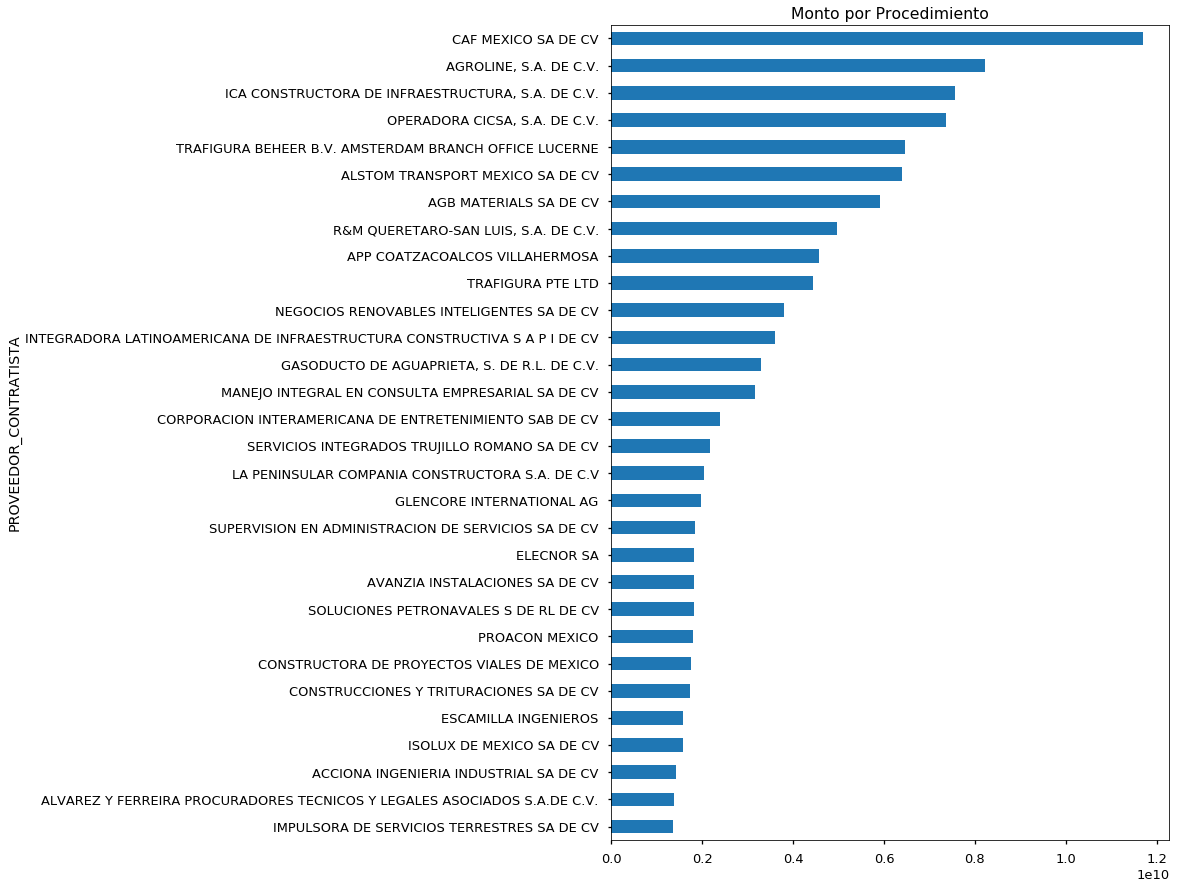

In [10]:
# numero empresas
num = 30
# col = 'PROCEDIMIENTOS'
# titulo = 'Número de Procedimientos'

# col = 'MONTO_PESOS'
# titulo = 'Monto Total'

# col = 'MONTO_por_PROC'
# titulo = 'Monto por Procedimiento'

with plt.style.context('seaborn-talk'):
    df_aux = df_empresas.set_index('PROVEEDOR_CONTRATISTA')[col].nlargest(num)
    df_aux.sort_values().plot.barh(figsize=(10, 15), title=titulo)
    # plt.tight_layout()

## Contratros y montos por dependencia


In [6]:
monto = df_validos.groupby('DEPENDENCIA', as_index=False).IMPORTE_PESOS.sum()
conteo = df_validos.groupby('DEPENDENCIA', as_index=False).NUMERO_PROCEDIMIENTO.count()
df_dependencias = pd.merge(conteo, monto, on='DEPENDENCIA', how='inner')
df_dependencias = df_dependencias.sort_values('IMPORTE_PESOS', ascending=False)
df_dependencias = df_dependencias.rename(
    columns={'NUMERO_PROCEDIMIENTO': 'PROCEDIMIENTOS', 'IMPORTE_PESOS': 'MONTO_PESOS'})
df_dependencias = df_dependencias.assign(
    MONTO_por_PROC=df_dependencias.MONTO_PESOS.divide(df_dependencias.PROCEDIMIENTOS))
# df_dependencias.to_csv(
# '../data/results/dependencias_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')
print(df_dependencias.shape)
df_dependencias.head()

(269, 4)


,DEPENDENCIA,PROCEDIMIENTOS,MONTO_PESOS,MONTO_por_PROC
69,COMISION FEDERAL DE ELECTRICIDAD,141872,3.920760e+11,2.763589e+06
162,INSTITUTO MEXICANO DEL SEGURO SOCIAL,104022,3.265710e+11,3.139442e+06
227,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,26364,3.010606e+11,1.141938e+07
152,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,37894,1.274725e+11,3.363924e+06
212,PETROLEOS MEXICANOS (CORPORATIVO),17013,7.064321e+10,4.152308e+06


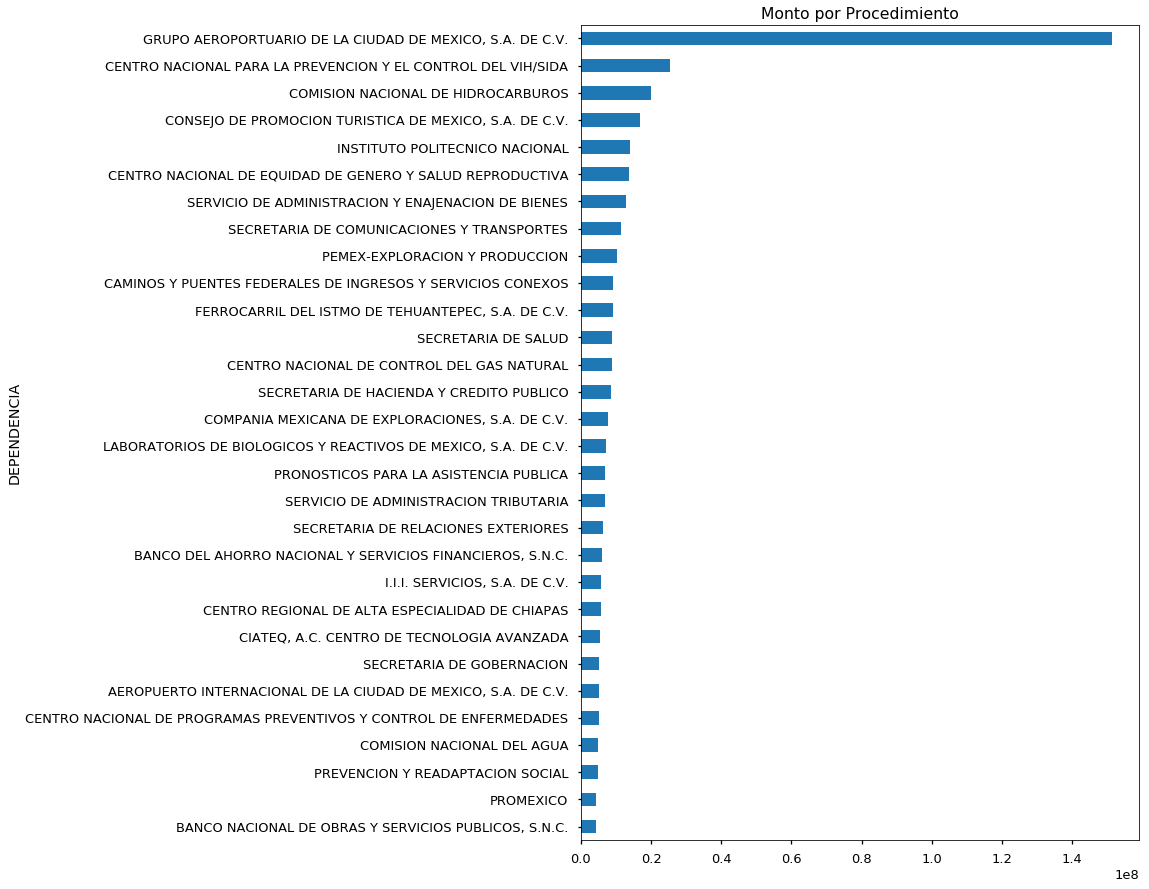

In [16]:
num = 30
# col = 'PROCEDIMIENTOS'
# titulo = 'Número de Procedimientos'

# col = 'MONTO_PESOS'
# titulo = 'Monto Total'

col = 'MONTO_por_PROC'
titulo = 'Monto por Procedimiento'

with plt.style.context('seaborn-talk'):
    df_aux = df_dependencias.set_index('DEPENDENCIA')[col].nlargest(num)
    df_aux.sort_values().plot.barh(figsize=(10, 15), title=titulo)

## Tipo de contratación

In [3]:
tipo_cont_monto = df_validos.groupby(['DEPENDENCIA', 'TIPO_CONTRATACION'], as_index=False).IMPORTE_PESOS.sum()
tipo_cont_conteo = df_validos.groupby(
    ['DEPENDENCIA', 'TIPO_CONTRATACION'], as_index=False).NUMERO_PROCEDIMIENTO.count()
df_depend_tipo_cont = pd.merge(
    tipo_cont_monto, tipo_cont_conteo, on=['DEPENDENCIA', 'TIPO_CONTRATACION'], how='inner')

df_depend_tipo_cont = df_depend_tipo_cont.sort_values('IMPORTE_PESOS', ascending=False)
print(tipo_cont_monto.shape, tipo_cont_conteo.shape)
print(df_depend_tipo_cont.shape)
df_depend_tipo_cont = df_depend_tipo_cont.rename(columns={'NUMERO_PROCEDIMIENTO': 'NUMERO_PROCEDIMIENTOS'})
df_depend_tipo_cont.to_csv(
    '../data/results/dependencias_tipo_contratacion_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')
df_depend_tipo_cont.head()

(1083, 3) (1083, 3)
(1083, 4)


,DEPENDENCIA,TIPO_CONTRATACION,IMPORTE_PESOS,NUMERO_PROCEDIMIENTOS
921,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,OBRA PUBLICA,2.255902e+11,13132
667,INSTITUTO MEXICANO DEL SEGURO SOCIAL,ADQUISICIONES,2.232493e+11,79923
305,COMISION FEDERAL DE ELECTRICIDAD,OBRA PUBLICA,1.662357e+11,20042
303,COMISION FEDERAL DE ELECTRICIDAD,ADQUISICIONES,1.414043e+11,73853
670,INSTITUTO MEXICANO DEL SEGURO SOCIAL,SERVICIOS,8.402085e+10,20422


In [5]:
df_validos.TIPO_CONTRATACION.unique()

array(['ADQUISICIONES', 'SERVICIOS', 'OBRA PUBLICA', 'ARRENDAMIENTOS',
       'SERVICIOS RELACIONADOS CON LA OP'], dtype=object)

In [6]:
df_validos.loc[
    df_validos.TIPO_CONTRATACION=='SERVICIOS RELACIONADOS CON LA OP', 'TIPO_CONTRATACION'
]='SR CON LA OP'

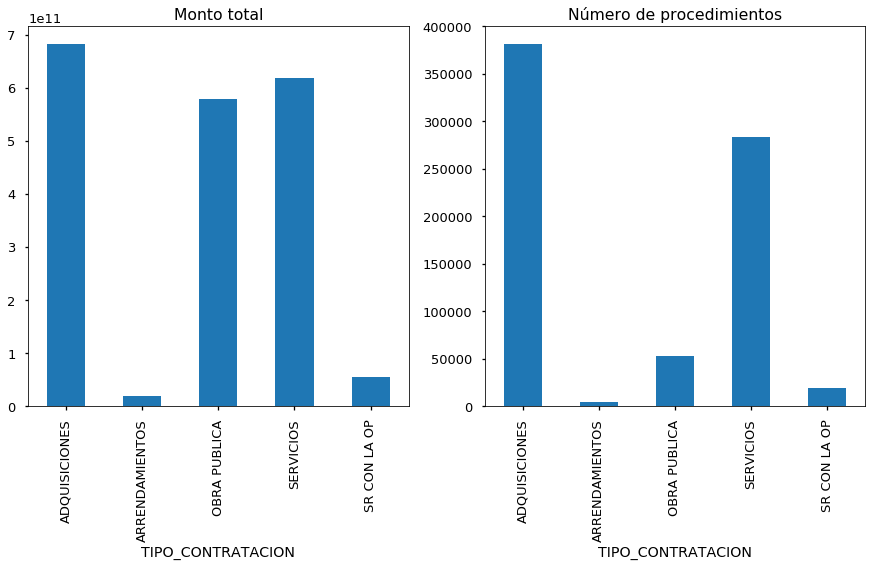

In [7]:
with plt.style.context('seaborn-talk'):
    fig, axs = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(15, 7))
    df_validos.groupby('TIPO_CONTRATACION').IMPORTE_PESOS.sum().plot.bar(
        title='Monto total', ax=axs[0])
    df_validos.groupby('TIPO_CONTRATACION').NUMERO_PROCEDIMIENTO.count().plot.bar(
        title='Número de procedimientos', ax=axs[1])

### Buscar outliers y representativos

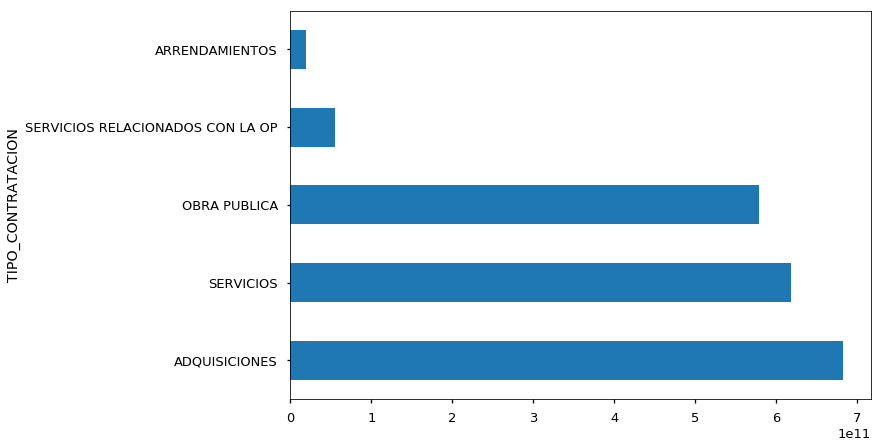

In [21]:
with plt.style.context('seaborn-talk'):
    df_depend_tipo_cont.groupby('TIPO_CONTRATACION').IMPORTE_PESOS.sum().sort_values(ascending=False).plot.barh()

## Tipo de PROCEDIMIENTO

In [5]:
tipo_proc_monto = df_validos.groupby(['DEPENDENCIA', 'TIPO_PROCEDIMIENTO'], as_index=False).IMPORTE_PESOS.sum()
tipo_proc_conteo = df_validos.groupby(
    ['DEPENDENCIA', 'TIPO_PROCEDIMIENTO'], as_index=False).NUMERO_PROCEDIMIENTO.count()
df_depend_tipo_proc = pd.merge(
    tipo_proc_monto, tipo_proc_conteo, on=['DEPENDENCIA', 'TIPO_PROCEDIMIENTO'], how='inner')

df_depend_tipo_proc = df_depend_tipo_proc.sort_values('IMPORTE_PESOS', ascending=False)
print(tipo_proc_monto.shape, tipo_proc_conteo.shape)
print(df_depend_tipo_proc.shape)
df_depend_tipo_proc = df_depend_tipo_proc.rename(columns={'NUMERO_PROCEDIMIENTO': 'NUMERO_PROCEDIMIENTOS'})
df_depend_tipo_proc.to_csv(
    '../data/results/dependencias_tipo_procedimiento_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')
df_depend_tipo_proc.head()

(883, 3) (883, 3)
(883, 4)


,DEPENDENCIA,TIPO_PROCEDIMIENTO,IMPORTE_PESOS,NUMERO_PROCEDIMIENTO
750,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,LICITACION PUBLICA,2.222640e+11,9216
226,COMISION FEDERAL DE ELECTRICIDAD,LICITACION PUBLICA,2.068393e+11,16092
535,INSTITUTO MEXICANO DEL SEGURO SOCIAL,LICITACION PUBLICA,1.923409e+11,25537
533,INSTITUTO MEXICANO DEL SEGURO SOCIAL,ADJUDICACION DIRECTA FEDERAL,9.647518e+10,72623
224,COMISION FEDERAL DE ELECTRICIDAD,ADJUDICACION DIRECTA FEDERAL,9.273415e+10,94391


## Forma procedimiento

In [11]:
forma_proc_monto = df_validos.groupby(['DEPENDENCIA', 'FORMA_PROCEDIMIENTO'], as_index=False).IMPORTE_PESOS.sum()
forma_proc_conteo = df_validos.groupby(
    ['DEPENDENCIA', 'FORMA_PROCEDIMIENTO'], as_index=False).NUMERO_PROCEDIMIENTO.count()
df_depend_forma_proc = pd.merge(
    forma_proc_monto, forma_proc_conteo, on=['DEPENDENCIA', 'FORMA_PROCEDIMIENTO'], how='inner')

df_depend_forma_proc = df_depend_forma_proc.sort_values('IMPORTE_PESOS', ascending=False)
print(forma_proc_monto.shape, forma_proc_conteo.shape)
print(df_depend_forma_proc.shape)
df_depend_forma_proc = df_depend_forma_proc.rename(columns={'NUMERO_PROCEDIMIENTO': 'NUMERO_PROCEDIMIENTOS'})
df_depend_forma_proc.to_csv(
    '../data/results/dependencias_forma_procedimiento_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')
df_depend_forma_proc.head()

(770, 3) (770, 3)
(770, 4)


,DEPENDENCIA,FORMA_PROCEDIMIENTO,IMPORTE_PESOS,NUMERO_PROCEDIMIENTOS
653,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,Presencial,1.969058e+11,17287
202,COMISION FEDERAL DE ELECTRICIDAD,Mixta,1.932568e+11,60331
201,COMISION FEDERAL DE ELECTRICIDAD,Electrónica,1.648517e+11,75836
462,INSTITUTO MEXICANO DEL SEGURO SOCIAL,Electrónica,1.264315e+11,36947
463,INSTITUTO MEXICANO DEL SEGURO SOCIAL,Mixta,1.104905e+11,40687


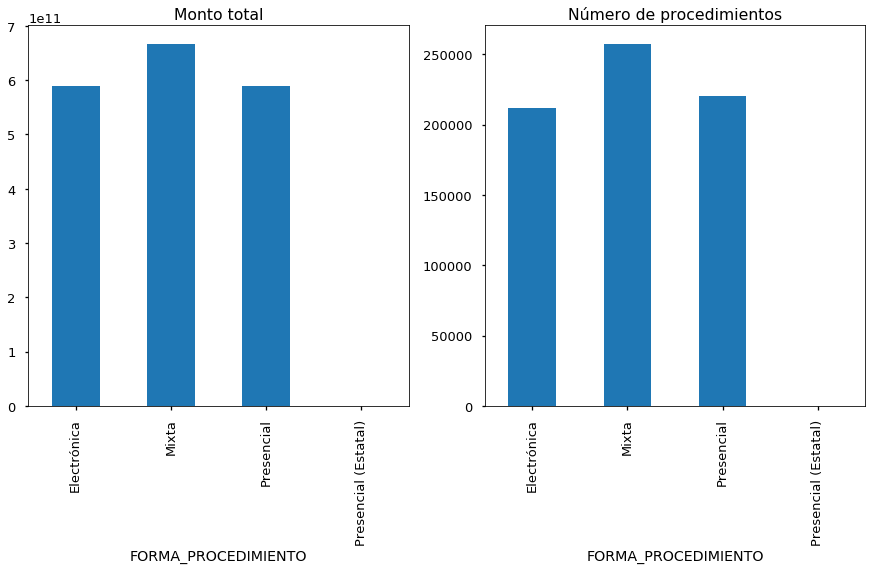

In [18]:
with plt.style.context('seaborn-talk'):
    fig, axs = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(15, 7))
    df_depend_forma_proc.groupby('FORMA_PROCEDIMIENTO').IMPORTE_PESOS.sum().plot.bar(title='Monto total', ax=axs[0])
    df_depend_forma_proc.groupby('FORMA_PROCEDIMIENTO').NUMERO_PROCEDIMIENTOS.sum().plot.bar(title='Número de procedimientos', ax=axs[1])

## Tipo de empresa

In [5]:
estrati_proc_monto = df_validos.groupby(['DEPENDENCIA', 'ESTRATIFICACION_MPC'], as_index=False).IMPORTE_PESOS.sum()
estrati_proc_conteo = df_validos.groupby(
    ['DEPENDENCIA', 'ESTRATIFICACION_MPC'], as_index=False).NUMERO_PROCEDIMIENTO.count()
df_depend_estrati = pd.merge(
    estrati_proc_monto, estrati_proc_conteo, on=['DEPENDENCIA', 'ESTRATIFICACION_MPC'], how='inner')

df_depend_estrati = df_depend_estrati.sort_values('IMPORTE_PESOS', ascending=False)
print(estrati_proc_monto.shape, estrati_proc_conteo.shape)
print(df_depend_estrati.shape)
df_depend_estrati = df_depend_estrati.rename(columns={'NUMERO_PROCEDIMIENTO': 'NUMERO_PROCEDIMIENTOS'})
df_depend_estrati.to_csv(
    '../data/results/dependencias_df_depend_estratificacion_mpc_montos.psv', encoding='utf-8', index=False, quoting=1, sep='|')
df_depend_estrati.head()

(1067, 3) (1067, 3)
(1067, 4)


,DEPENDENCIA,ESTRATIFICACION_MPC,IMPORTE_PESOS,NUMERO_PROCEDIMIENTOS
645,INSTITUTO MEXICANO DEL SEGURO SOCIAL,NO MIPYME,1.976513e+11,17638
278,COMISION FEDERAL DE ELECTRICIDAD,NO MIPYME,1.435630e+11,11187
900,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,MEDIANA,1.162169e+11,7681
279,COMISION FEDERAL DE ELECTRICIDAD,PEQUENA,9.852177e+10,47521
276,COMISION FEDERAL DE ELECTRICIDAD,MEDIANA,9.119739e+10,30919


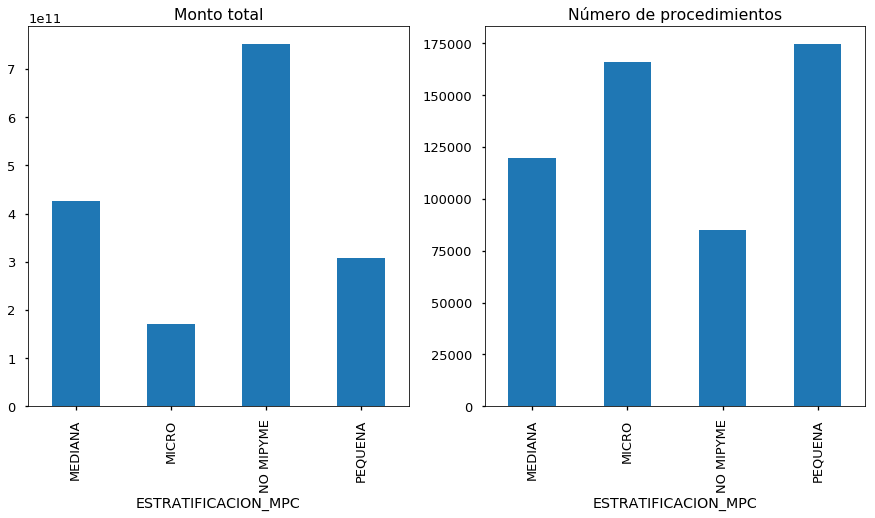

In [10]:
with plt.style.context('seaborn-talk'):
    fig, axs = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(15, 7))
    df_validos.groupby('ESTRATIFICACION_MPC').IMPORTE_PESOS.sum().plot.bar(
        title='Monto total', ax=axs[0])
    df_validos.groupby('ESTRATIFICACION_MPC').NUMERO_PROCEDIMIENTO.count().plot.bar(
        title='Número de procedimientos', ax=axs[1])

In [9]:
df_validos.groupby('ESTRATIFICACION_MPC').NUMERO_PROCEDIMIENTO.count()

ESTRATIFICACION_MPC
MEDIANA      119711
MICRO        165772
NO MIPYME     84817
PEQUENA      174687
Name: NUMERO_PROCEDIMIENTO, dtype: int64

In [7]:
df_validos.groupby('ESTRATIFICACION_MPC').NUMERO_PROCEDIMIENTOS.count()

ESTRATIFICACION_MPC
MEDIANA      119711
MICRO        165772
NO MIPYME     84817
PEQUENA      174687
Name: NUMERO_PROCEDIMIENTOS, dtype: int64

In [ ]:
df_depend_tipo_proc = df_depend_tipo_proc.rename(columns={'NUMERO_PROCEDIMIENTO': 'NUMERO_PROCEDIMIENTOS'})

In [6]:
df_validos.loc[(~df_validos.PROVEEDOR_CONTRATISTA.isnull())].loc[(df_validos.PROVEEDOR_CONTRATISTA.str.startswith('EDGAR FRANCISO'))]

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS


In [7]:
df_validos.FORMA_PROCEDIMIENTO.value_counts(dropna=False)

Mixta                   257646
Presencial              220104
Electrónica             212014
NaN                      51825
Presencial (Estatal)        41
Name: FORMA_PROCEDIMIENTO, dtype: int64

In [4]:
df_validos.TIPO_PROCEDIMIENTO.value_counts(dropna=False)

ADJUDICACION DIRECTA FEDERAL            544752
LICITACION PUBLICA                      111928
INVITACION A CUANDO MENOS 3 PERSONAS     83061
OTRO                                      1205
LICITACION PUBLICA CON OSD                 388
PROYECTO DE CONVOCATORIA                   295
NaN                                          1
Name: TIPO_PROCEDIMIENTO, dtype: int64

## De las fechas revisar cuando son inician

In [76]:
df_validos.columns
df_salida = df_validos.loc[:, 
    ['PROC_F_PUBLICACION', 'FECHA_APERTURA_PROPOSICIONES', 'EXP_F_FALLO',
     'FECHA_CELEBRACION', 'FECHA_INICIO', 'FECHA_FIN']]

In [17]:
df_validos = df_validos.assign(
    DIA_INICIO=df_validos.FECHA_INICIO.dt.dayofyear,
    DIA_FIN=df_validos.FECHA_FIN.dt.dayofyear
)

In [18]:
conteo_inicio = df_validos.groupby('DIA_INICIO').NUMERO_PROCEDIMIENTO.count()
conteo_inicio.index.name = 'Dia del año'
conteo_fin = df_validos.groupby('DIA_FIN').NUMERO_PROCEDIMIENTO.count()
conteo_fin.index.name = 'Dia del año'

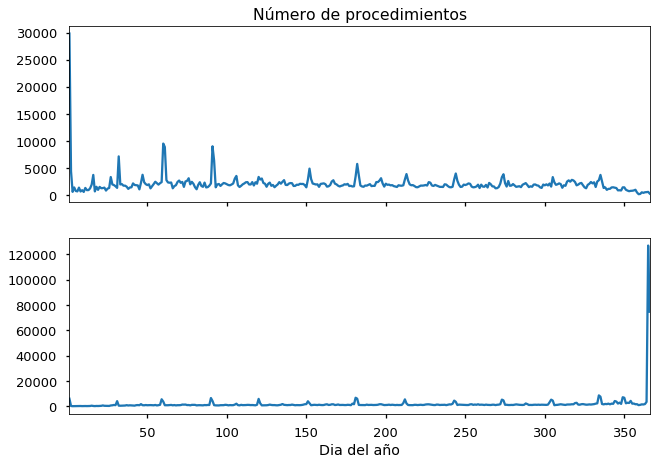

In [19]:
with plt.style.context('seaborn-talk'):
    fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True)
    conteo_inicio.plot(ax=axs[0], title='Número de procedimientos')
    conteo_fin.plot(ax=axs[1])

## Responsables y empresas

In [5]:
# dep_top_50 = df_validos.loc[
#     :, ['RESPONSABLE', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']
# ].groupby(['RESPONSABLE', 'PROVEEDOR_CONTRATISTA']).IMPORTE_PESOS.sum().sort_values(ascending=False)# .reset_index()
# with plt.style.context('seaborn-talk'):
#     dep_top_50.head(30).plot.barh()

In [4]:
# dep_top_50.head(25).reset_index().set_index('RESPONSABLE')

In [7]:
df_test = df_validos.loc[~df_validos.PROVEEDOR_CONTRATISTA.isnull()]

In [9]:
df_test.loc[df_test.PROVEEDOR_CONTRATISTA.str.startswith('EDGAR FRANCISCO ZAMBRANO TAVARES')]

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS
252786,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-HOSPITAL REGIONAL LEON,019GYN025,ERNESTO ANTONIO ABOYTES VELAZQUEZ,MICRO,nan,EDGAR FRANCISCO ZAMBRANO TAVARES,HABILITADO,None,1.597610e+06,NaN,MXN,LA-019GYN025-N14-2012,Mixta,LICITACION PUBLICA,509505,ALIMENTACION DE PERSONAS,None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,0.0,NaN,2012-12-06 12:49:00,2012-12-21 09:00:00,2012-12-28,2013-01-01,2013-01-01,2015-10-09,317032,ADQUISICION DE BIENES PERECEDEROS,01. Licitación Pública Nacional LAASSP,None,UC,None,No,None,NaN,None,NaN,1.597610e+06
775492,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-HOSPITAL REGIONAL LEON #019GYN025,019GYN025,ERNESTO ANTONIO ABOYTES VELAZQUEZ,MICRO,nan,EDGAR FRANCISCO ZAMBRANO TAVARES,HABILITADO,None,7.000000e+04,NaN,MXN,AA-019GYN025-E18-2016,Presencial,ADJUDICACION DIRECTA FEDERAL,988347,ADQUISICION DE PRODUCTOS PERECEDEROS LACTEOS,None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,NaN,0.0,NaT,NaT,NaT,2016-01-04,2016-01-01,2016-02-29,991051,ADQUISICION DE PRODUCTOS PERECEDEROS LACTEOS,05. Adjudicación Directa LAASSP,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,7.000000e+04
775558,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-HOSPITAL REGIONAL LEON #019GYN025,019GYN025,ERNESTO ANTONIO ABOYTES VELAZQUEZ,MICRO,nan,EDGAR FRANCISCO ZAMBRANO TAVARES,HABILITADO,None,1.800000e+05,NaN,MXN,AA-019GYN025-E17-2016,Presencial,ADJUDICACION DIRECTA FEDERAL,988345,ADQUISICION DE PRODUCTOS PERECEDEROS CARNE PRO...,None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,NaN,0.0,NaT,NaT,NaT,2016-01-04,2016-01-01,2016-02-29,991049,ADQUISICION DE PRODUCTOS PERECEDEROS CARNE PRO...,05. Adjudicación Directa LAASSP,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,1.800000e+05
775582,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,ISSSTE,ISSSTE-HOSPITAL REGIONAL LEON #019GYN025,019GYN025,ERNESTO ANTONIO ABOYTES VELAZQUEZ,MICRO,nan,EDGAR FRANCISCO ZAMBRANO TAVARES,HABILITADO,None,1.961184e+09,NaN,MXN,LA-019GYN025-E1-2016,Mixta,LICITACION PUBLICA,1032104,"ABARROTES, SUMINISTRO DE CARNICOS, PRODUCTOS V...",None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,NaN,0.0,2016-01-20 15:09:00,2016-02-05 09:00:00,2016-02-15,2016-02-19,2016-03-01,2016-12-31,980806,ADQUISICION DE BIENES PERECEDEROS,01. Licitación Pública LAASSP,None,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,1.961184e+09


In [41]:
df_test.loc[df_test.PROVEEDOR_CONTRATISTA.str.startswith('MANEJO INTEGRAL EN CONSULTA')]

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS
336392,APF,"COMPANIA MEXICANA DE EXPLORACIONES, S.A. DE C.V.",COMESA,COMESA-DEPARTAMENTO DE COMPRAS #018TQA001,018TQA001,JUAN FERNANDO MEZA ZAVALA,NO MIPYME,nan,MANEJO INTEGRAL EN CONSULTA EMPRESARIAL SA DE CV,HABILITADO,NO MIPYME,1.477527e+09,NaN,MXN,SA-018TQA001-N165-2014,Electrónica,ADJUDICACION DIRECTA FEDERAL,633778,PRESTACION DE SERVICIOS ESPECIALIZADOS,None,ADQUISICIONES,EXPIRADO,0.0,1.0,Nacional,0.0,0.0,NaT,NaT,NaT,NaT,2014-10-29,2015-10-28,707734,PRESTACION DE SERVICIOS ESPECIALIZADOS,Z15122015 12. Adjudicación Directa Nacional Si...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,1.477527e+09
336479,APF,"COMPANIA MEXICANA DE EXPLORACIONES, S.A. DE C.V.",COMESA,COMESA-DEPARTAMENTO DE COMPRAS #018TQA001,018TQA001,JUAN FERNANDO MEZA ZAVALA,NO MIPYME,nan,MANEJO INTEGRAL EN CONSULTA EMPRESARIAL SA DE CV,HABILITADO,NO MIPYME,4.831805e+09,NaN,MXN,LA-018TQA001-N35-2014,Electrónica,LICITACION PUBLICA,500478,PRESTACION DE SERVICIOS ESPECIALIZADOS,None,SERVICIOS,ACTIVO,0.0,1.0,Nacional,0.0,0.0,2014-02-17 17:21:00,2014-03-04 10:00:00,2014-03-13,NaT,2014-04-25,2017-04-24,545539,PRESTACION DE SERVICIOS ESPECIALIZADOS,Z15122015 01. Licitación Pública Nacional LAASSP,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,4.831805e+09


In [12]:
df_test.loc[df_test.PROVEEDOR_CONTRATISTA.str.startswith('GRUPO CONSTRUCTOR CESECO')].sort_values('FECHA_INICIO')

,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS
22440,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-SUBDIRECCION DE SERVICIOS GENERALES #03...,03890O002,MARIA ELENA CASTRO NUNEZ,MICRO,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,6976222.60,NaN,MXN,SO-03890O002-N306-2012,Mixta,ADJUDICACION DIRECTA FEDERAL,144880,CONSTRUCCION DEL PARQUE CIENTIFICO Y TECNOLOGI...,None,OBRA PUBLICA,EXPIRADO,0.0,0.0,Nacional,0.0,0.0,NaT,NaT,NaT,2012-07-09,2012-07-10,2012-11-10,214994,CONSTRUCCION DEL PARQUE CIENTIFICO Y TECNOLOGI...,Z15122015 24. Adjudicación Directa Nacional Si...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,6976222.60
22439,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-SUBDIRECCION DE SERVICIOS GENERALES #03...,03890O002,MARIA ELENA CASTRO NUNEZ,MICRO,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,0.00,NaN,MXN,SO-03890O002-N306-2012,Mixta,ADJUDICACION DIRECTA FEDERAL,268939,CONVENIO NO. 1 OP12-018-GCC,None,OBRA PUBLICA,EXPIRADO,0.0,0.0,Nacional,0.0,1.0,NaT,NaT,NaT,NaT,2012-07-11,2012-11-30,214994,CONSTRUCCION DEL PARQUE CIENTIFICO Y TECNOLOGI...,Z15122015 24. Adjudicación Directa Nacional Si...,None,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,None,NaN,0.00
212427,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-SUBDIRECCION DE SERVICIOS GENERALES,03890O002,MARIA ELENA CASTRO NUNEZ,NO MIPYME,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,189100.00,NaN,MXN,SA-03890O002-N488-2013,None,ADJUDICACION DIRECTA FEDERAL,383275,TRABAJOS EDIFICIO DE BIOHELIS,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,NaN,NaT,NaT,NaT,NaT,2013-02-27,2013-03-06,459907,MTO TRABAJOS EDIFICIO DE BIOHELIS,12. Adjudicación Directa Nacional Simplificada...,None,PoC,None,No,None,NaN,None,NaN,189100.00
224270,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-DEPARTAMENTO DE CONTROL PATRIMONIAL,03890O001,JOSE MATEO RAMOS RODRIGUEZ,MICRO,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,35000.00,NaN,MXN,SA-03890O001-N151-2013,None,ADJUDICACION DIRECTA FEDERAL,307978,PRODUCTOS MINERALES NO METALICOS,None,ADQUISICIONES,EXPIRADO,0.0,0.0,Nacional,0.0,NaN,NaT,NaT,NaT,NaT,2013-03-05,2013-04-04,364065,PRODUCTOS MINERALES NO METALICOS,12. Adjudicación Directa Nacional Simplificada...,None,PoC,None,No,None,NaN,None,NaN,35000.00
212333,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-SUBDIRECCION DE SERVICIOS GENERALES,03890O002,MARIA ELENA CASTRO NUNEZ,NO MIPYME,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,224250.00,NaN,MXN,SA-03890O002-N505-2013,None,ADJUDICACION DIRECTA FEDERAL,383669,TRABAJOS EDIFICIO DE BIOHELIS,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,NaN,NaT,NaT,NaT,NaT,2013-03-21,2013-04-01,460525,MTO TRABAJOS EDIFICIO BIOHELIS,12. Adjudicación Directa Nacional Simplificada...,None,PoC,None,No,None,NaN,None,NaN,224250.00
212441,CENTRO DE INVESTIGACIONES BIOLOGICAS DEL NOROE...,CIBNOR,CIBNOR-SUBDIRECCION DE SERVICIOS GENERALES,03890O002,MARIA ELENA CASTRO NUNEZ,NO MIPYME,nan,GRUPO CONSTRUCTOR CESECO SA DE CV,HABILITADO,MEDIANA,68400.00,NaN,MXN,SA-03890O002-N521-2013,None,ADJUDICACION DIRECTA FEDERAL,383894,TRABAJOS BIOHELIS,None,SERVICIOS,EXPIRADO,0.0,0.0,Nacional,0.0,NaN,NaT,NaT,NaT,NaT,2013-04-18,2013-04-25,460844,MTO TRABAJOS BIOHELIS,12. Adjudicación Directa Nacional S

In [ ]:
# http://mx.kompass.com/c/manejo-integral-en-consulta-empresarial-sa-de-cv/mx825564/

In [ ]:
df_validos.loc[:, ['CLAVEUC', 'RESPONSABLE', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']]

In [14]:
salida = df_validos.loc[:, ['CLAVEUC', 'RESPONSABLE', 'IMPORTE_PESOS']].groupby(['CLAVEUC', 'RESPONSABLE']).IMPORTE_PESOS.count()

## UC que más gastan


In [9]:
dep_top_50 = set(df_dependencias.sort_values('MONTO_PESOS', ascending=False).DEPENDENCIA.head(50).values)

In [ ]:
df_validos.loc[df_validos.DEPENDENCIA.isin(dep_top_50)].groupby(NOMBRE_DE_LA_UC)

## Serie de tiempo y agregados por monto

In [43]:
df_tiempo = df_validos.loc[:, ['NOMBRE_DE_LA_UC', 'IMPORTE_PESOS', 'FECHA_INICIO']].set_index('FECHA_INICIO')

df_tiempo = df_tiempo.groupby(
    'NOMBRE_DE_LA_UC'
).resample('Q').IMPORTE_PESOS.sum().reset_index().sort_values('FECHA_INICIO').set_index('FECHA_INICIO')



In [44]:
df_tiempo = df_tiempo.pivot(columns='NOMBRE_DE_LA_UC', values='IMPORTE_PESOS')

In [46]:
ucs = list(df_tiempo.sum(axis=0).nlargest(8).index.values)

In [6]:
# df_tiempo

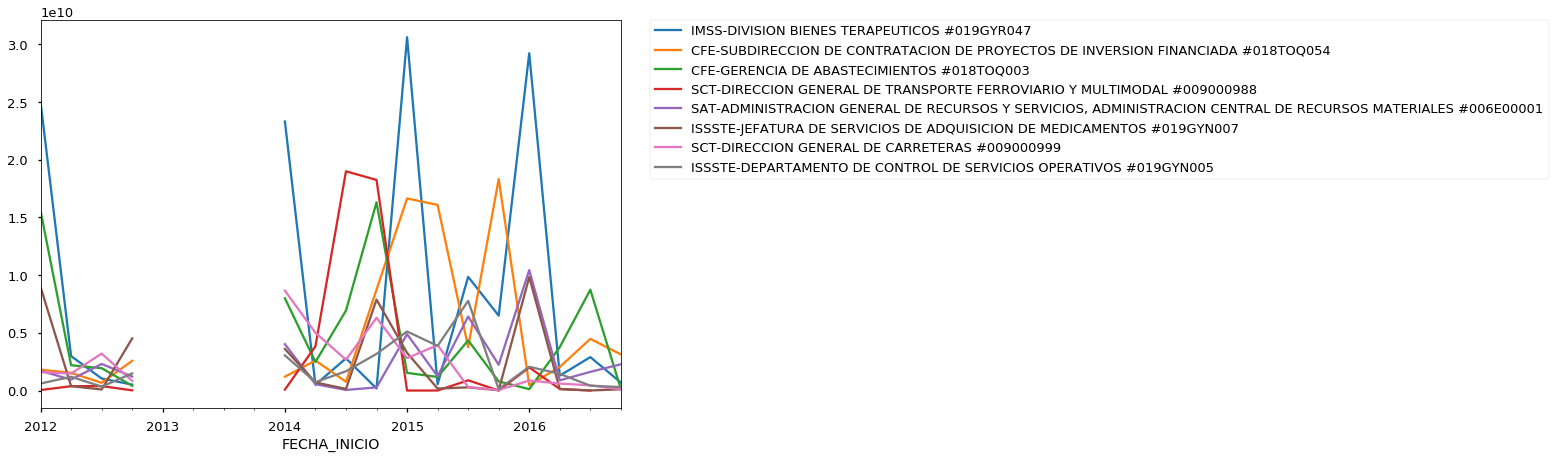

In [53]:
with plt.style.context('seaborn-talk'):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    df_tiempo.loc[:, ucs].plot(ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [7]:
# df_tiempo.loc[:, ucs]

In [37]:
'CFE-SUBDIRECCION DE CONTRATACION DE PROYECTOS DE INVERSION FINANCIADA #018TOQ054' in set(df_validos.loc[df_validos.FECHA_INICIO.dt.year == 2013].NOMBRE_DE_LA_UC.unique())

False

In [8]:
# df_tiempo.set_index('FECHA_INICIO').resample('M').sum()

In [ ]:
df_tiempo = df_validos.loc[:, ['NOMBRE_DE_LA_UC', 'IMPORTE_PESOS', 'FECHA_INICIO']]
mean_valor = df_tiempo.assign(Mes=df_tiempo.FECHA_INICIO.dt.month).groupby(['NOMBRE_DE_LA_UC', 'Mes']).IMPORTE_PESOS.sum()
df_tiempo

In [ ]:
mean_valor.reset_index().groupby('NOMBRE_DE_LA_UC').IMPORTE_PESOS.mean().sort_values(ascending=False)

## Scraper

In [9]:
# df_scraper = pd.read_csv('../data/processed/data_scraper_2017_06_12.csv', sep='|', dtype={'codigo_expediente': str})
# df_scraper = df_scraper.drop(['id_compranet', 'notas', 'url', 'web'], axis=1)
# df_scraper.head()

## Netorkx to cytoscope

In [3]:
df_network = df_validos.loc[
    :, ['DEPENDENCIA', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']
].groupby(
    ['DEPENDENCIA', 'PROVEEDOR_CONTRATISTA']
).IMPORTE_PESOS.sum().reset_index().sort_values('IMPORTE_PESOS', ascending=False).reset_index(drop=True)

# df_network = df_network.rename(columns={'IMPORTE_PESOS': 'weight'})
total = df_network.IMPORTE_PESOS.sum()
df_network = df_network.assign(weight=(df_network.IMPORTE_PESOS * 100).divide(total))
print(df_network.shape)
df_network.head()

(206634, 4)


,DEPENDENCIA,PROVEEDOR_CONTRATISTA,IMPORTE_PESOS,weight
0,INSTITUTO MEXICANO DEL SEGURO SOCIAL,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,3.928184e+10,2.010118
1,INSTITUTO DE SEGURIDAD Y SERVICIOS SOCIALES DE...,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,2.353539e+10,1.204346
2,PETROLEOS MEXICANOS (CORPORATIVO),SEGUROS INBURSA SA GRUPO FINANCIERO INBUR SA,1.640500e+10,0.839472
3,INSTITUTO MEXICANO DEL SEGURO SOCIAL,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,1.635799e+10,0.837066
4,COMISION FEDERAL DE ELECTRICIDAD,SIEMENS INNOVACIONES SA DE CV,1.482338e+10,0.758538


In [16]:
# with plt.style.context('seaborn-talk'):
#     df_network.weight.cumsum().plot()

In [4]:
# Reduced Network
df_network = df_network.loc[df_network.weight.cumsum() < 90]
print(df_network.shape)

(13878, 4)


In [5]:
mixtos = set(df_network.DEPENDENCIA.unique()) & set(df_network.PROVEEDOR_CONTRATISTA.unique())
dependencias = {d: 'Dependencia' for d in df_network.DEPENDENCIA.unique() if d not in mixtos}
pocs = {p: 'PoC' for p in df_network.PROVEEDOR_CONTRATISTA.unique() if p not in mixtos}
mixtos = {m: 'Mixto' for m in mixtos}
tipo_att = {**dependencias, **pocs, **mixtos}
print(len(dependencias), len(pocs), len(mixtos))
del dependencias, pocs, mixtos
len(tipo_att)

225 10665 14


10904

In [6]:
# Size de DEPENDENCIAS y de POC

monto_pocs = df_validos.loc[
    (df_validos.PROVEEDOR_CONTRATISTA.isin(df_network.PROVEEDOR_CONTRATISTA.unique()))
].groupby('PROVEEDOR_CONTRATISTA').IMPORTE_PESOS.sum()

monto_dep = df_validos.loc[
    (df_validos.DEPENDENCIA.isin(df_network.DEPENDENCIA.unique()))
].groupby('DEPENDENCIA').IMPORTE_PESOS.sum()

minimo = min(monto_dep.min(), monto_pocs.min())

monto_pocs = monto_pocs.divide(minimo)
monto_dep = monto_dep.divide(minimo)

monto_pocs = {k: float(v) for k, v in monto_pocs.to_dict().items()}
monto_dep = {k: float(v) for k, v in monto_dep.to_dict().items()}

size_att = {**monto_dep, **monto_pocs}

df_size = pd.Series(size_att)
df_size.name = 'monto'
df_size.index.name = 'Nodo'
df_size = (df_size.apply(np.log) + 1) * 6

size_att = df_size.sort_values(ascending=False).to_dict()
size_att = {k: float(v) for k, v in size_att.items()}

forma_att = {k: 'Circulo' for k in size_att}
len(size_att)

10904

In [18]:
G = nx.from_pandas_dataframe(df_network, 'DEPENDENCIA', 'PROVEEDOR_CONTRATISTA', 'weight', nx.DiGraph())
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 10904
Number of edges: 13878
Average degree:   2.5455


In [8]:
nx.set_node_attributes(G, 'Tipo', tipo_att)
nx.set_node_attributes(G, 'Forma', forma_att)
nx.set_node_attributes(G, 'Montos', size_att)

In [9]:
max(size_att.values()), min(size_att.values())

(67.3351987019933, 6.0)

In [14]:
nx.write_graphml(G, '../data/processed/DEPENDENCIAS_PoCs.graphml')

In [19]:
nx.get_node_attributes(G, 'weight')

{}

In [67]:
df_validos.loc[df_validos.DEPENDENCIA == 'INSTITUTO MEXICANO DEL SEGURO SOCIALINSTITUTO MEXICANO DEL SEGURO SOCIALINSTITUTO MEXICANO DEL SEGURO SOCIAL']

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO,IMPORTE_PESOS


In [ ]:
df_size.log_monto.sort_values(ascending=False).to_dict

In [ ]:
df_size.set_index('Nodo').log_monto.to_dict

In [10]:
# df_size.log_monto.describe()

In [35]:
# print([g.number_of_nodes() for g in nx.connected_component_subgraphs(G, copy=False)])


In [40]:
df_validos.DEPENDENCIA.nunique(), df_validos.SIGLAS.nunique()

(335, 307)

In [70]:
# df_validos.loc[
#     :, ['DEPENDENCIA', 'SIGLAS']
# ].drop_duplicates(['DEPENDENCIA', 'SIGLAS']).groupby('DEPENDENCIA').SIGLAS.count().sort_values(ascending=False)

In [46]:
df_test = df_validos.loc[
    :, ['DEPENDENCIA', 'SIGLAS']
].drop_duplicates(['DEPENDENCIA', 'SIGLAS'])

df_test.loc[df_test.DEPENDENCIA == '_GOBIERNO MUNICIPAL DEL ESTADO DE CIUDAD DE MEXICO']

,DEPENDENCIA,SIGLAS
8534,_GOBIERNO MUNICIPAL DEL ESTADO DE CIUDAD DE ME...,DF
304361,_GOBIERNO MUNICIPAL DEL ESTADO DE CIUDAD DE ME...,CDMX


In [9]:
df_procedimientos.SIGLAS.value_counts(dropna=False).shape

(307,)

In [5]:

# df_validos.loc[df_validos.MONEDA != 'MXN', ['IMPORTE_CONTRATO', 'MONEDA', 'IMPORTE_PESOS', 'FECHA_INICIO']].head(10)


In [33]:
# df_validos.loc[
#     :, 'PROVEEDOR_CONTRATISTA'
# ] = df_validos.PROVEEDOR_CONTRATISTA.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.upper()

## Red reducida

In [70]:
df_network = df_validos.loc[
    :, ['SIGLAS', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']
].groupby(
    ['SIGLAS', 'PROVEEDOR_CONTRATISTA']
).IMPORTE_PESOS.sum().reset_index().sort_values('IMPORTE_PESOS', ascending=False).reset_index(drop=True)

df_network = df_network.rename(columns={'IMPORTE_PESOS': 'weight'})
total = df_network.weight.sum()
df_network.loc[:, 'weight'] = (df_network.weight * 100).divide(total)

In [13]:
# with plt.style.context('seaborn-talk'):
#     df_network.weight.cumsum().plot()

In [71]:
df_network = df_network.loc[df_network.weight.cumsum() < 90]
print(df_network.shape)
df_network.to_csv('../data/processed/SIGLAS_PoC_monto_reducida.csv', index=False, encoding='utf-8', quoting=1)
df_network.head()

(22427, 3)


,SIGLAS,PROVEEDOR_CONTRATISTA,weight
0,IMSS,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1.680510
1,ISSSTE,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1.005723
2,NL,CONSTRUCCIONES Y MAQUINARIA GUTIERREZ SA DE CV,0.972398
3,PEMEX,SEGUROS INBURSA SA GRUPO FINANCIERO INBUR SA,0.702136
4,IMSS,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,0.694667


# Network

In [2]:
colores = {
    'Responsable': '#fc8d62', # naranja
    'PoC': '#8da0cb', # Azul?
}


In [3]:
df_network = pd.read_csv('../data/processed/SIGLAS_PoC_monto_reducida.csv')
print(df_network.shape)
# df_network.loc[:, 'weight'] = (df_network.weight * 100)
df_network.head()

(22427, 3)


,SIGLAS,PROVEEDOR_CONTRATISTA,weight
0,IMSS,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1.680510
1,ISSSTE,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1.005723
2,NL,CONSTRUCCIONES Y MAQUINARIA GUTIERREZ SA DE CV,0.972398
3,PEMEX,SEGUROS INBURSA SA GRUPO FINANCIERO INBUR SA,0.702136
4,IMSS,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,0.694667


In [8]:
siglas = {s: colores['Responsable'] for s in df_network.SIGLAS.unique()}
pocs = {p: colores['PoC'] for p in df_network.PROVEEDOR_CONTRATISTA.unique()}

color_att = {**siglas, **pocs}

In [42]:
# network SIGLAS - PROVEEDOR_CONTRATISTA

# df_network = df_validos.loc[
#     :, ['SIGLAS', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']
# ].groupby(
#     ['SIGLAS', 'PROVEEDOR_CONTRATISTA']
# ).IMPORTE_PESOS.sum().reset_index().sort_values('IMPORTE_PESOS', ascending=False)

# df_network = df_network.rename(columns={'IMPORTE_PESOS': 'weight'})

# df_network.to_csv('../data/processed/SIGLAS_PoC_monto.csv', index=False, encoding='utf-8', quoting=1)

# # df_network = pd.read_csv('../data/processed/SIGLAS_PoC_monto.csv')
# print(df_network.SIGLAS.nunique(), df_network.PROVEEDOR_CONTRATISTA.nunique(), df_network.shape[0])
# df_network.head()

In [5]:
# # network RESPONSABLE - PROVEEDOR_CONTRATISTA

# # df_network = df_validos.loc[
# #     :, ['RESPONSABLE', 'PROVEEDOR_CONTRATISTA', 'IMPORTE_PESOS']
# # ].groupby(
# #     ['RESPONSABLE', 'PROVEEDOR_CONTRATISTA']
# # ).IMPORTE_PESOS.sum().reset_index().sort_values('IMPORTE_PESOS', ascending=False)

# # df_network = df_network.rename(columns={'IMPORTE_PESOS': 'weight'})

# # df_network.to_csv('../data/processed/responsable_PoC_monto.csv', index=False, encoding='utf-8', quoting=1)

# df_network = pd.read_csv('../data/processed/responsable_PoC_monto.csv')
# # df_network.loc[:, 'RESPONSABLE'] = df_network.RESPONSABLE.str.strip()
# # df_network.loc[:, 'PROVEEDOR_CONTRATISTA'] = df_network.PROVEEDOR_CONTRATISTA.str.strip()
# print(df_network.RESPONSABLE.nunique(), df_network.PROVEEDOR_CONTRATISTA.nunique(), df_network.shape[0])
# df_network.head()



4476 162330 325816


,RESPONSABLE,PROVEEDOR_CONTRATISTA,weight
0,FERMIN BENITEZ GIRON,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,2.969003e+10
1,REYNALDO RAMIREZ HERNANDEZ,CONSTRUCCIONES Y MAQUINARIA GUTIERREZ SA DE CV,2.265258e+10
2,JESSICA MAQUEDA RAMOS,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,1.793019e+10
3,PATRICIA ANTONIA MARTINEZ NIEVES,SEGUROS INBURSA SA GRUPO FINANCIERO INBUR SA,1.452360e+10
4,FERMIN BENITEZ GIRON,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,1.420699e+10


In [11]:
G = nx.from_pandas_dataframe(df_network, 'SIGLAS', 'PROVEEDOR_CONTRATISTA', 'weight', nx.Graph())
print(nx.info(G))

In [12]:
# no dan las cuentas ? # 162330 + 4476 = 166806
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 17435
Number of edges: 22427
Average degree:   2.5726


In [13]:
nx.set_node_attributes(G, 'color', color_att)

In [14]:
color_test = nx.get_node_attributes(G,'color')

In [7]:
[g.number_of_nodes() for g in nx.connected_component_subgraphs(G, copy=False)]
nx.write_graphml(G, '../data/processed/test_Siglas_colors.graphml')

[17407, 5, 2, 3, 4, 2, 3, 2, 3, 2, 2]

In [ ]:
nx.set_node_attributes

In [16]:
nx.write_graphml(G, '../data/processed/test_Siglas_colors.graphml')

In [11]:
# with plt.style.context('seaborn-talk'):
#     nx.draw_spectral(G)

In [56]:
pos = nx.spectral_layout(G)

In [9]:
# montos gastados por RESPONSABLE

# df_responsables = df_validos.groupby('RESPONSABLE').IMPORTE_PESOS.sum().reset_index()
# df_responsables.to_csv('../data/processed/responsables_monto.csv', index=False, encoding='utf-8', quoting=1)
df_responsables = pd.read_csv('../data/processed/responsables_monto.csv')
df_responsables = df_responsables.rename(columns={'IMPORTE_PESOS': 'Size', 'RESPONSABLE': 'Nodo'})
df_responsables = df_responsables.assign(Color=colores['Responsable'])
df_responsables.head()

,Nodo,Size,Color
0,AARON BALDERAS CRUZ,2.495026e+07,#fc8d62
1,AARON EDGARDO ZAMORA SANCHEZ,9.502386e+06,#fc8d62
2,AARON VELAZQUEZ PORTAS,1.150870e+05,#fc8d62
3,ABDI ABIHUD RAMIREZ PEREZ,1.678387e+07,#fc8d62
4,ABDIAS CASTILLO CASTILLO,1.029095e+07,#fc8d62


In [15]:
# montos ganados por PROVEEDOR_CONTRATISTA
# df_PoC = df_validos.groupby(
#     'PROVEEDOR_CONTRATISTA').IMPORTE_PESOS.sum().reset_index().sort_values('IMPORTE_PESOS', ascending=False)
# df_PoC.to_csv('../data/processed/PoC_monto.csv', index=False, encoding='utf-8', quoting=1)1
df_PoC = pd.read_csv('../data/processed/PoC_monto.csv')
df_PoC = df_PoC.rename(columns={'IMPORTE_PESOS': 'Size', 'PROVEEDOR_CONTRATISTA': 'Nodo'})
df_PoC.head()

,Nodo,Size
0,GRUPO FARMACOS ESPECIALIZADOS SA DE CV,6.549621e+10
1,"FARMACEUTICOS MAYPO, S.A. DE C.V.",2.727799e+10
2,CONSTRUCCIONES Y MAQUINARIA GUTIERREZ SA DE CV,2.272587e+10
3,DISTRIBUIDORA INTERNACIONAL DE MEDICAMENTOS Y ...,2.225919e+10
4,SIXSIGMA NETWORKS MEXICO,1.988440e+10


In [60]:
# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(G)

In [51]:
# nx.draw_graphviz(G)

## Bokeh network

In [78]:
def graph_draw(g, layout=nx.circular_layout, node_color="white", text_color="black"):
    pos = layout(g)
    labels = [ str(v) for v in g.nodes() ]
    vx, vy = zip(*[ pos[v] for v in g.nodes() ])
    xs, ys = [], []
    for (a, b) in g.edges():
        x0, y0 = pos[a]
        x1, y1 = pos[b]
        xs.append([x0, x1])
        ys.append([y0, y1])
    tools = "pan,wheel_zoom,box_zoom,reset"
    f = figure(plot_width=900, plot_height=700, x_axis_type=None, y_axis_type=None,
               outline_line_color=None,
               tools=tools, toolbar_location='right')
    f.multi_line(xs, ys, line_color="black", line_width=1)
    f.circle(vx, vy, size=5, line_color="black", fill_color=node_color)
    return f

In [52]:
pos = nx.circular_layout(G)

In [ ]:
p = graph_draw(G, nx.spring_layout)
show(p)

In [ ]:
# V = range(1, 12+1)
# E = [(1,2),(2,3),(1,4),(1,6),(1,12),(2,5),(2,7),(3,8),(3,10),(4,11),(4,9),(5,6),
#      (6,7),(7,8),(8,9),(9,10),(10,11),(11,12),(5,12),(5,9),(6,10),(7,11),(8,12)]

# g = nx.Graph()
# g.add_nodes_from(V)
# g.add_edges_from(E)
# p = graph_draw(g, nx.spectral_layout)
# show(p)

In [59]:
# def graph_draw_pos(g, pos, node_color="white", text_color="black"):
#     # pos = layout(g)
#     labels = [ str(v) for v in g.nodes() ]
#     vx, vy = zip(*[ pos[v] for v in g.nodes() ])
#     xs, ys = [], []
#     for (a, b) in g.edges():
#         x0, y0 = pos[a]
#         x1, y1 = pos[b]
#         xs.append([x0, x1])
#         ys.append([y0, y1])
#     tools = "pan,wheel_zoom,box_zoom,reset"
#     f = figure(plot_width=900, plot_height=700, x_axis_type=None, y_axis_type=None,
#                outline_line_color=None,
#                tools=tools, toolbar_location='right')
#     f.multi_line(xs, ys, line_color="black", line_width=1)
#     f.circle(vx, vy, size=5, line_color="black", fill_color=node_color)
#     return f

# p = graph_draw_pos(G, pos)
# show(p)

In [24]:
df_validos.loc[df_validos.NUMERO_PROCEDIMIENTO == 'AA-004E2D001-N220-2015']

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,CLAVE_CARTERA_SHCP,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO
323505,APF,TALLERES GRAFICOS DE MEXICO,TGM,TGM-Gerencia de Abastecimientos,004E2D001,FIDENCIO RUEDA GARCIA,Pequeña,nan,BURO MEXICANO DE CONSULTORES EN SEGURIDAD INFO...,HABILITADO,Pequeña,NaN,38266.7,NaN,MXN,AA-004E2D001-N220-2015,Mixta,adjudicacion directa federal,836208,POLIZA,NaN,servicios,Activo,0.0,0.0,Nacional,0.0,NaN,NaT,2015-03-17,NaT,2015-03-17,2013-03-17,2015-12-31,889094,POLIZA,07. Adjudicación Directa Nacional Art. 42 LAASSP,NaN,PoC,NaN,No,NaN,NaN,NaN,NaN
675441,APF,TALLERES GRAFICOS DE MEXICO,TGM,TGM-Gerencia de Abastecimientos #004E2D001,004E2D001,FIDENCIO RUEDA GARCIA,Pequeña,nan,BURO MEXICANO DE CONSULTORES EN SEGURIDAD INFO...,HABILITADO,Pequeña,NaN,38266.7,NaN,MXN,AA-004E2D001-N220-2015,Electrónica,adjudicacion directa federal,836208,POLIZA,NaN,servicios,Expirado,0.0,0.0,Nacional,0.0,0.0,NaT,2015-03-17,NaT,2015-03-17,2015-03-17,2015-12-31,889094,POLIZA,Z15122015 07. Adjudicación Directa Nacional Ar...,NaN,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN


In [12]:
# df_conteos.loc[df_conteos.GOBIERNO > 1, :]

In [15]:
df_conteos.GOBIERNO.value_counts(dropna=False)

1    806139
2       474
4         3
Name: GOBIERNO, dtype: int64

In [4]:
df_procedimientos.ESTATUS_CONTRATO.value_counts(dropna=False)

Expirado     798699
Terminado     54067
Activo         8403
Name: ESTATUS_CONTRATO, dtype: int64

In [11]:
# df_procedimientos.CODIGO_EXPEDIENTE.value_counts()

In [79]:
df_procedimientos.loc[df_procedimientos.CODIGO_EXPEDIENTE == '680310'].CONVENIO_MODIFICATORIO.value_counts()

0.0    205
Name: CONVENIO_MODIFICATORIO, dtype: int64

In [65]:
df_procedimientos.CONVENIO_MODIFICATORIO.value_counts(dropna=False).divide(df_procedimientos.shape[0])

 0.0    0.816374
NaN     0.164790
 1.0    0.018836
Name: CONVENIO_MODIFICATORIO, dtype: float64

In [64]:
df_procedimientos.CONVENIO_MODIFICATORIO.value_counts(dropna=False)

 0.0    703036
NaN     141912
 1.0     16221
Name: CONVENIO_MODIFICATORIO, dtype: int64

## Datos Scraper

In [36]:
scraper_cols = [
    # 'id_compranet',
    'unidad_compradora',
    'categorias_expediente',
    'email_operador_UC',
    'entidad',
    'nombre_operador_UC',
    'notas',
    'codigo_expediente',
    'descripcion_expediente',
    # 'descripcion_anuncio',
    'duracion_contrato',
    'tipo_expediente',
    'tipo_contratacion',
    'fecha_publicacion',
    'plazo_participacion',
    'fecha_inicio_contrato',
    'fecha_conclusion',
    'fecha_ultima_actualizacion',
    'referencia_expediente',
    # 'timestamp',
    # 'url',
    'web'
]

df_scraper = pd.read_csv('../data/processed/data_scraper_2017_06_12.csv', dtype=str, sep='|', usecols=scraper_cols)
df_scraper.head()

,unidad_compradora,categorias_expediente,email_operador_UC,entidad,nombre_operador_UC,notas,codigo_expediente,descripcion_expediente,duracion_contrato,tipo_expediente,tipo_contratacion,fecha_publicacion,plazo_participacion,fecha_inicio_contrato,fecha_conclusion,fecha_ultima_actualizacion,referencia_expediente,web
0,CFE-Subdirección de Distribución División Sure...,NaN,jose.paredes02@cfe.gob.mx,No especificado por la UC,Paredes Aquino Jose Carlos,Paredes Aquino Jose Carlos,486,"DK040-003-2010 ""18164159-015-10 REAISLAMIENTO ...",90 DIAS NATURALES,sub110525_16. Licitación Pública Nacional LOPSRM,No especificado por la UC,NaN,07/01/2011 12:00 AM,28/02/2011,326504.46,NaN,ZONA TUXTLA 9400059349,NaN
1,CFE-Subdirección de Distribución División Sure...,NaN,jose.paredes02@cfe.gob.mx,No especificado por la UC,Paredes Aquino Jose Carlos,Paredes Aquino Jose Carlos,483,"DK040-003-2010 ""18164159-014-10 REPOTENCIACION...",120 DIAS NATURALES,sub110525_16. Licitación Pública Nacional LOPSRM,No especificado por la UC,NaN,07/01/2011 12:00 AM,28/02/2011,2487186.93,NaN,ZONA TUXTLA 9400059354,NaN
2,SECTUR-Secretaría,"3360 - Servicios de apoyo administrativo, trad...",afbalderas@sectur.gob.mx,Ciudad de México,Flores Balderas Anselmo,Flores Balderas Anselmo,501,Vales de Despensa de Fin de Año 2010,NaN,Z15122015 12. Adjudicación Directa Nacional Si...,Adquisiciones,NaN,10/12/2010 12:00 AM,NaN,NaN,NaN,PA/049/2010,NaN
3,CAPUFE-Gerencia de Recursos Materiales,NaN,jrojas@capufe.gob.mx,No especificado por la UC,Rojas Rojas Juan,Rojas Rojas Juan,502,Suministro de combustible y lubricantes a trav...,NaN,sub110525_01. Licitación Pública Nacional LAASSP,No especificado por la UC,NaN,15/12/2010 12:00 AM,NaN,NaN,NaN,NaN,NaN
4,ISSSTE-Subdirección Administrativa Hospital Re...,"2610 - Combustibles, lubricantes y aditivos",rcolosio@issste.gob.mx,No especificado por la UC,Colosio Franco Ricardo,Colosio Franco Ricardo,509,Adquisición de combustibles para calderas y pl...,del 01/01/2011 al 31/12/2011,sub110525_01. Licitación Pública Nacional LAASSP,No especificado por la UC,NaN,27/12/2010 12:00 AM,01/01/2011,NaN,NaN,LA-019GYN024-N3-2011,NaN


In [37]:
codigos_expediente = set(df_scraper.codigo_expediente.unique())
df_found = df_procedimientos.loc[df_procedimientos.CODIGO_EXPEDIENTE.isin(codigos_expediente)]

In [13]:
# df_scraper.codigo_expediente.value_counts(dropna=False)

In [61]:
df_scraper.loc[df_scraper.codigo_expediente == '193840']

,unidad_compradora,categorias_expediente,email_operador_UC,entidad,nombre_operador_UC,notas,codigo_expediente,descripcion_expediente,duracion_contrato,tipo_expediente,tipo_contratacion,fecha_publicacion,plazo_participacion,fecha_inicio_contrato,fecha_conclusion,fecha_ultima_actualizacion,referencia_expediente,web
101784,CONAGUA-ORGANISMO CUENCA AGUAS DEL VALLE DE ME...,"2610 - Combustibles, lubricantes y aditivos",josejuan.rueda@conagua.gob.mx,Ciudad de México,Rueda Maldonado Jose Juan,Rueda Maldonado Jose Juan,193840,ADQUISICIÓN DE COMBUSTIBLE DIESEL,NaN,Z15122015 01. Licitación Pública Nacional LAASSP,Adquisiciones,01/06/2012 01:52 PM,18/06/2012 10:00 AM,NaN,NaN,01/06/2012 01:52 PM,COMBUSTIBLE DIESEL,NaN
101786,CONAGUA-ORGANISMO CUENCA AGUAS DEL VALLE DE ME...,"2610 - Combustibles, lubricantes y aditivos",josejuan.rueda@conagua.gob.mx,Ciudad de México,Rueda Maldonado Jose Juan,Rueda Maldonado Jose Juan,193840,ADQUISICIÓN DE COMBUSTIBLE DIESEL,NaN,Z15122015 01. Licitación Pública Nacional LAASSP,Adquisiciones,01/06/2012 01:52 PM,18/06/2012 10:00 AM,NaN,NaN,01/06/2012 01:52 PM,COMBUSTIBLE DIESEL,NaN


In [14]:
# df_procedimientos.CLAVEUC.value_counts()

In [15]:
# df_scraper.unidad_compradora.value_counts(dropna=False)

In [58]:
# df_procedimientos.loc[df_procedimientos.CODIGO_EXPEDIENTE.isin(df_scraper.referencia_expediente.unique())].shape

(2075, 45)

In [44]:
861169 - 848578

12591

In [45]:
df_scraper.codigo_expediente.value_counts()

193227     2
194089     2
194022     2
193840     2
1120519    1
1096302    1
1222266    1
679487     1
1203616    1
457481     1
621643     1
1075035    1
1015818    1
70064      1
901745     1
555946     1
599834     1
1086540    1
647204     1
476194     1
868223     1
383858     1
697757     1
182189     1
525373     1
663421     1
1031876    1
652444     1
1073725    1
960585     1
1180766    1
720620     1
1063075    1
250766     1
31440      1
1024493    1
245415     1
417262     1
1111066    1
689267     1
492355     1
1292640    1
676475     1
827817     1
1292624    1
305664     1
1211423    1
956681     1
131676     1
1034598    1
          ..
1114935    1
1083877    1
604114     1
163999     1
1138167    1
447280     1
1147455    1
1175112    1
561700     1
62368      1
1206271    1
498097     1
186999     1
641504     1
149217     1
478273     1
624416     1
74576      1
592396     1
790985     1
581656     1
203174     1
1020698    1
1153590    1
928385     1
323687     1

In [46]:
df_procedimientos.CODIGO_EXPEDIENTE.value_counts()

553734     2166
193814      940
203285      782
611478      514
655931      427
524814      397
618908      347
1057086     337
618885      320
990044      304
989931      301
553432      294
984617      269
652020      227
995114      222
861665      217
329941      216
749183      214
329988      212
1057068     211
193029      209
1016661     207
680310      205
557793      200
753100      190
799520      188
444848      188
247683      185
535958      183
832083      175
579870      175
840090      171
746919      167
214997      167
444267      163
768821      162
539551      157
840101      152
535954      152
984301      152
839140      152
745596      148
214979      148
581941      145
621495      141
720206      138
621904      138
585887      135
444895      134
839152      132
           ... 
1244996       1
378903        1
708165        1
757065        1
336302        1
523702        1
618530        1
1118116       1
1140146       1
831444        1
937897        1
1171823 

In [47]:
df_found.CODIGO_EXPEDIENTE.value_counts()

553734     2166
193814      940
203285      782
611478      514
655931      427
524814      397
618908      347
1057086     337
618885      320
990044      304
989931      301
553432      294
984617      269
652020      227
861665      217
329941      216
749183      214
329988      212
1057068     211
193029      209
1016661     207
680310      205
557793      200
753100      190
799520      188
444848      188
247683      185
535958      183
579870      175
832083      175
840090      171
214997      167
746919      167
444267      163
768821      162
539551      157
535954      152
839140      152
840101      152
984301      152
214979      148
745596      148
581941      145
621495      141
621904      138
720206      138
585887      135
444895      134
839152      132
981024      131
           ... 
927183        1
1236274       1
1100351       1
675691        1
389162        1
676006        1
374631        1
950377        1
640604        1
971208        1
995801        1
111207  

In [51]:
df_found.loc[df_found.CODIGO_EXPEDIENTE == '553734'].TIPO_PROCEDIMIENTO.value_counts()

adjudicacion directa federal    2166
Name: TIPO_PROCEDIMIENTO, dtype: int64

In [2]:
# # joblib read

# def get_df(name):
#     df = pd.read_excel('{0}'.format(name),
#                        dtype={
#                            'FOLIO_RUPC': str, 'CLAVEUC': str, 'CODIGO_CONTRATO': str,
#                            'CODIGO_EXPEDIENTE': str, 'FOLIO_RUPC': str
#                        }
#                       )
#     df.loc[:, 'PROC_F_PUBLICACION'] = pd.to_datetime(df.PROC_F_PUBLICACION, yearfirst=True)
#     df.loc[:, 'FECHA_APERTURA_PROPOSICIONES'] = pd.to_datetime(df.FECHA_APERTURA_PROPOSICIONES, yearfirst=True)
#     df.loc[:, 'EXP_F_FALLO'] = pd.to_datetime(df.EXP_F_FALLO, yearfirst=True)
#     df.loc[:, 'FECHA_CELEBRACION'] = pd.to_datetime(df.FECHA_CELEBRACION, yearfirst=True)
#     df.loc[:, 'FECHA_INICIO'] = pd.to_datetime(df.FECHA_INICIO, yearfirst=True)
#     df.loc[:, 'FECHA_FIN'] = pd.to_datetime(df.FECHA_FIN, yearfirst=True)
#     cols = [
#         'ESTRATIFICACION_MUC', 'NOMBRE_DE_LA_UC', 'RESPONSABLE', 'DEPENDENCIA', 'PROVEEDOR_CONTRATISTA',
#         'ESTRATIFICACION_MPC', 'TITULO_EXPEDIENTE', 'TITULO_CONTRATO', 'TIPO_CONTRATACION',
#         'TIPO_PROCEDIMIENTO', 'ESTATUS_EMPRESA', 'ESTATUS_CONTRATO', 'SIGLAS'
#     ]
#     for col in cols:
#         df.loc[:, col] = df[col].str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.upper()
#         df.loc[:, col] = df[col].str.strip()
#     return df

# file_names = [
#     '../data/raw/Procedimiento de Contratación 2010-2012.xlsx',
#     '../data/raw/Procedimiento de Contratación 2013.xlsx',
#     '../data/raw/Procedimiento de Contratación 2014.xlsx',
#     '../data/raw/Procedimiento de Contratación 2015.xlsx',
#     '../data/raw/Procedimiento de Contratación 2016.xlsx'
# ]

# df_procedimientos = joblib.Parallel(n_jobs=-1, batch_size=1)(joblib.delayed(get_df)(name) for name in file_names)
# df_procedimientos = pd.concat(df_procedimientos, axis=0, ignore_index=True)
# df_procedimientos = df_procedimientos.loc[(df_procedimientos.FECHA_INICIO.dt.year > 2011), :]



# print(df_procedimientos.shape)



# ordered_cols = [
#     'GOBIERNO',
#     # Dependencia/unidad/responsable
#     'DEPENDENCIA',
#     'SIGLAS',    
#     'NOMBRE_DE_LA_UC',
#     'CLAVEUC',
#     'RESPONSABLE',
#     'ESTRATIFICACION_MUC',
#     # proveedor
#     'FOLIO_RUPC',
#     'PROVEEDOR_CONTRATISTA',
#     'ESTATUS_EMPRESA',
#     'ESTRATIFICACION_MPC',
#     'CLAVE_CARTERA_SHCP',
#     # montos
#     'IMPORTE_CONTRATO',
#     'APORTACION_FEDERAL',
#     'MONEDA',
#     # datos procedimiento
#     'NUMERO_PROCEDIMIENTO',
#     'FORMA_PROCEDIMIENTO',
#     'TIPO_PROCEDIMIENTO',
#     # datos contrato
#     'CODIGO_CONTRATO',
#     'TITULO_CONTRATO',
#     'IDENTIFICADOR_CM',
#     'TIPO_CONTRATACION',
#     'ESTATUS_CONTRATO',
#     'COMPRA_CONSOLIDADA',
#     'PLURIANUAL',
#     'CARACTER',
#     'CONTRATO_MARCO',
#     'CONVENIO_MODIFICATORIO',
        
#     # datos del bien

#     # Fechas ordenadas
#     'PROC_F_PUBLICACION',
#     'FECHA_APERTURA_PROPOSICIONES',
#     'EXP_F_FALLO',
#     'FECHA_CELEBRACION',
#     'FECHA_INICIO',
#     'FECHA_FIN',
#     # expediente
#     'CODIGO_EXPEDIENTE',
#     'TITULO_EXPEDIENTE',
#     'PLANTILLA_EXPEDIENTE',
#     # otros
#     'CLAVE_PROGRAMA',
#     'CUENTA_ADMINISTRADA_POR',
#     'ANUNCIO',
#     'ARCHIVADO',
#     'SIGLAS_PAIS',
#     'RAMO',
#     'ORGANISMO',
#     'C_EXTERNO',
# ]
# df_procedimientos = df_procedimientos.loc[:, ordered_cols]
# print(df_procedimientos.shape)

# # df_procedimientos.loc[:, 'RESPONSABLE'] = df_procedimientos.RESPONSABLE.str.strip()
# # df_procedimientos.loc[:, 'PROVEEDOR_CONTRATISTA'] = df_procedimientos.PROVEEDOR_CONTRATISTA.str.strip()

# # clean_cols = [
# #     'NUMERO_PROCEDIMIENTO', 'CODIGO_CONTRATO', 'CODIGO_EXPEDIENTE',
# #     'ESTATUS_CONTRATO', 'DEPENDENCIA', 'SIGLAS', 'NOMBRE_DE_LA_UC'
# # ]

# # for col in clean_cols:
# #     df_procedimientos.loc[:, col] = df_procedimientos[col].str.strip()

# ## Save

# # df_procedimientos.drop(
# #     'CLAVE_CARTERA_SHCP', axis=1
# # ).to_csv('../data/processed/procedimientos_2017_06_14.csv', index=False, quoting=1, encoding='utf-8', sep='|')

# # feather.write_dataframe(
# #     df_procedimientos.drop('CLAVE_CARTERA_SHCP', axis=1), '../data/processed/procedimientos_2017_06_14.feather')

# df_procedimientos.head()

In [50]:
df_scraper.loc[df_scraper.codigo_expediente == '553734']

,unidad_compradora,categorias_expediente,email_operador_UC,entidad,nombre_operador_UC,notas,codigo_expediente,descripcion_expediente,duracion_contrato,tipo_expediente,tipo_contratacion,fecha_publicacion,plazo_participacion,fecha_inicio_contrato,fecha_conclusion,fecha_ultima_actualizacion,referencia_expediente,web
712828,IMSS-Coordinación de abastecimiento y equipami...,"2540 - Materiales, accesorios y suministros mé...",gustavo.esquer@imss.gob.mx,Sonora,Gustavo Esquer Apodaca,Gustavo Esquer Apodaca,553734,COMPRAS DE UNIDADES,NaN,Z15122015 12. Adjudicación Directa Nacional Si...,Adquisiciones,02/12/2015 12:24 PM,04/02/2014 11:00 AM,NaN,NaN,02/12/2015 12:24 PM,ADIMSS-SA-019GYR031-N61-2014,NaN


In [ ]:
df_procedimientos.loc[df_procedimientos.ESTATUS_CONTRATO]

# empezar con únicos en contratos y agragar valores, ver rotacion etc

In [12]:
# Filtrar

df_salida = df_procedimientos.loc[df_procedimientos.PLURIANUAL == 0]
df_salida = df_salida.loc[df_salida.ESTATUS_CONTRATO != 'Expirado']
df_salida.head()

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,CLAVE_CARTERA_SHCP,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO
81,APF,AEROPUERTOS Y SERVICIOS AUXILIARES,ASA,ASA-Estación de Combustibles del Aeropuerto de...,009JZL032,JOSE LUIS ALMADA PENUNURI,Micro,nan,MIGUEL ROJAS PUENTE,HABILITADO,NaN,NaN,54750.00,NaN,MXN,AA-009JZL032-N5-2012,Mixta,adjudicacion directa federal,272929,Hojalateria y Pintura de Unidades de Apoyo y D...,NaN,servicios,Terminado,0.0,0.0,Nacional,0.0,0.0,2012-10-19 21:07:00,2012-10-29 12:00:00,NaT,NaT,2012-11-13,2012-12-31,273449,"Trabajos de Hojalateria y Pintura de unidades,...",Z15122015 07. Adjudicación Directa Nacional Ar...,NaN,UC,https://compranet.funcionpublica.gob.mx/esop/g...,Si,MX,NaN,NaN,NaN
603,APF,CENTRO NACIONAL PARA LA PREVENCION Y EL CONTRO...,CENSIDA,CENSIDA-Coordinación Administrativa #012K00999,012K00999,EDUARDO MANTECON AGUILAR,No MIPYME,nan,FORZA TRAVEL SA DE CV,HABILITADO,Pequeña,NaN,85251.89,NaN,MXN,SA-012K00999-N35-2012,Mixta,adjudicacion directa federal,220100,PAQUETES DE ALIMENTOS,NaN,servicios,Terminado,0.0,0.0,Nacional,0.0,0.0,NaT,NaT,NaT,2012-07-12,2012-07-12,2012-12-31,283819,PAQUETES DE ALIMENTOS,Z15122015 12. Adjudicación Directa Nacional Si...,NaN,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN
605,APF,CENTRO NACIONAL PARA LA PREVENCION Y EL CONTRO...,CENSIDA,CENSIDA-Coordinación Administrativa #012K00999,012K00999,EDUARDO MANTECON AGUILAR,No MIPYME,nan,RAUL DURAN NAVARRETE,HABILITADO,NaN,NaN,195000.00,NaN,MXN,SA-012K00999-N32-2012,Mixta,adjudicacion directa federal,220057,INFORMACIÓN ELECTRONICA SOBRE ACTUALIDADES DEL...,NaN,servicios,Terminado,0.0,0.0,Nacional,0.0,0.0,NaT,NaT,NaT,2012-06-29,2012-06-29,2012-12-31,283779,INFORMACION ELECTRONICA SOBRE ACTUALIDADES DEL...,Z15122015 12. Adjudicación Directa Nacional Si...,NaN,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN
607,APF,CENTRO NACIONAL PARA LA PREVENCION Y EL CONTRO...,CENSIDA,CENSIDA-Coordinación Administrativa #012K00999,012K00999,EDUARDO MANTECON AGUILAR,No MIPYME,nan,ANUAR ISMAEL LUNA CADENA,HABILITADO,NaN,NaN,202587.00,NaN,MXN,SA-012K00999-N26-2012,Mixta,adjudicacion directa federal,220009,PRIORIDADES Y RETOS DE TRABAJO,NaN,servicios,Terminado,0.0,0.0,Nacional,0.0,0.0,NaT,NaT,NaT,2012-06-29,2012-06-29,2012-12-31,283695,PRIORIDADES Y RETOS DE TRABAJO,Z15122015 12. Adjudicación Directa Nacional Si...,NaN,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN
611,APF,CENTRO NACIONAL PARA LA PREVENCION Y EL CONTRO...,CENSIDA,CENSIDA-Coordinación Administrativa #012K00999,012K00999,EDUARDO MANTECON AGUILAR,No MIPYME,nan,MA. DEL ROSARIO PADILLA GARCIA,HABILITADO,NaN,NaN,185345.00,NaN,MXN,SA-012K00999-N25-2012,Mixta,adjudicacion directa federal,220003,PRIORIDADES Y RETOS DE TRABAJO,NaN,servicios,Terminado,0.0,0.0,Nacional,0.0,0.0,NaT,NaT,NaT,2012-06-29,2012-06-29,2012-12-31,283682,PRIORIDADES Y RETOS DE TRABAJO,Z15122015 12. Adjudicación Directa Nacional Si...,NaN,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN


In [13]:
df_salida.ESTATUS_CONTRATO.value_counts(dropna=True)

Terminado    53472
Activo        3391
Name: ESTATUS_CONTRATO, dtype: int64

In [ ]:
df_salida.loc[df_salida.ESTATUS_CONTRATO == 'Terminado']

In [ ]:
# filtrar
df_salida = df_procedimientos.loc[]

In [4]:
df_procedimientos[df_procedimientos.CODIGO_EXPEDIENTE == '1131377']

,GOBIERNO,DEPENDENCIA,SIGLAS,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,CLAVE_CARTERA_SHCP,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO


In [19]:
# Procedimientos <-> Directorio de unidades
# 'CLAVEUC' (Tiene campos con el tamaño incorrecto) == 'Clave UC en CompraNet'
# 'NOMBRE_DE_LA_UC' == 'Nombre UC en CompraNet' 
# 'DEPENDENCIA' == 'Dependencia o Entidad' 
# 'SIGLAS' == 'Siglas'
# 'RESPONSABLE' == 'Nombre del Responsable'

In [ ]:
'Proveedores y Contratistas Sancionados.xlsx', 'PASOP APF,GE,CDMX,GM.csv'

In [ ]:
df_PASOP = pd.read_csv('../data/raw/PASOP APF,GE,CDMX,GM.csv', dtype=str, encoding='iso-8859-1')
df_PASOP.head()

In [ ]:
## Conecta proveedores con dependencias
# 'Proveedor o Contratista'
# 'Dependencia'


df_sancionados = pd.read_excel(
    '../data/raw/Proveedores y Contratistas Sancionados.xlsx',
    dtype={'Monto': float, 'Número de Expediente': str}, 
)
df_sancionados.loc[:, 'Fecha de Notificación'] = pd.to_datetime(
    df_sancionados['Fecha de Notificación'], yearfirst=True, errors='coerce')
df_sancionados.loc[:, 'Fecha de Resolución'] = pd.to_datetime(
    df_sancionados['Fecha de Resolución'], yearfirst=True, errors='coerce')

df_sancionados.head()

In [30]:
# df_sancionados.loc[df_sancionados['Número de Expediente         '] == '0001/2015', :]

In [ ]:
df_sancionados

In [10]:
df_test = pd.merge(df_registro, df_procedimientos, on='FOLIO_RUPC', how='inner')

## Analisis de NO plurianuales

In [9]:
df_anuales = df_procedimientos.loc[df_procedimientos.PLURIANUAL == 0, :]
delta_dias = (df_anuales.FECHA_FIN - df_anuales.FECHA_INICIO).dt.days


In [29]:
# with plt.style.context('seaborn-talk'):
#     delta_dias.plot.hist(100)

In [28]:
# df_procedimientos.APORTACION_FEDERAL.value_counts(dropna=True)

In [11]:
delta_fechas = df_procedimientos.FECHA_FIN - df_procedimientos.FECHA_INICIO

In [15]:
delta_dias = delta_fechas.dt.days

In [53]:

# from itertools import combinations
# for col1, col2, col3 in zip(df_dir_fed.columns, df_dir_est.columns, df_dir_mun.columns):
#     print(all(n1 == n2 for n1, n2 in combinations((col1, col2, col3), 2)))

In [26]:
df_procedimientos.loc[[801688, 129110, 3856, 236105]]

,GOBIERNO,SIGLAS,DEPENDENCIA,NOMBRE_DE_LA_UC,CLAVEUC,RESPONSABLE,ESTRATIFICACION_MUC,FOLIO_RUPC,PROVEEDOR_CONTRATISTA,ESTATUS_EMPRESA,ESTRATIFICACION_MPC,CLAVE_CARTERA_SHCP,IMPORTE_CONTRATO,APORTACION_FEDERAL,MONEDA,NUMERO_PROCEDIMIENTO,FORMA_PROCEDIMIENTO,TIPO_PROCEDIMIENTO,CODIGO_CONTRATO,TITULO_CONTRATO,IDENTIFICADOR_CM,TIPO_CONTRATACION,ESTATUS_CONTRATO,COMPRA_CONSOLIDADA,PLURIANUAL,CARACTER,CONTRATO_MARCO,CONVENIO_MODIFICATORIO,PROC_F_PUBLICACION,FECHA_APERTURA_PROPOSICIONES,EXP_F_FALLO,FECHA_CELEBRACION,FECHA_INICIO,FECHA_FIN,CODIGO_EXPEDIENTE,TITULO_EXPEDIENTE,PLANTILLA_EXPEDIENTE,CLAVE_PROGRAMA,CUENTA_ADMINISTRADA_POR,ANUNCIO,ARCHIVADO,SIGLAS_PAIS,RAMO,ORGANISMO,C_EXTERNO
801688,APF,CFE,COMISION FEDERAL DE ELECTRICIDAD,CFE-Gerencia de Abastecimientos #018TOQ003,018TOQ003,LUIS FERNANDO CASTRO VIEYRA,No MIPYME,nan,GAS NATURAL DEL NOROESTE S.A. DE C.V.,HABILITADO,NaN,NaN,1.241867e+07,NaN,USD,CE-018TOQ003-E66-2016,Presencial,otro,1240254,SERVICIO DE TRANSPORTE DE GAS NATURAL POR GASO...,NaN,servicios,Activo,0.0,1.0,Internacional,NaN,0.0,NaT,NaT,2016-06-30,NaT,2016-05-01,2041-12-31,1018708,SERVICIO DE TRANSPORTE DE GAS NATURAL POR GASO...,08. Reporte de otras contrataciones y contrata...,NaN,UC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,0.0
129110,APF,BANOBRAS,"BANCO NACIONAL DE OBRAS Y SERVICIOS PUBLICOS, ...",BANOBRAS-DIRECCION FIDUCIARIA #006G1C003,006G1C003,MARIO EMILIO SIGUENZA CAMACHO,No MIPYME,nan,OPERADORA DE AUTOPISTAS ALDESEM SA DE CV,HABILITADO,No MIPYME,NaN,6.710367e+08,NaN,MXN,XX-006G1C003-X2-2012,Presencial,licitacion publica,196006,"Contrato de Prestación de Servicios, para la O...",NaN,servicios,Activo,0.0,1.0,Internacional,NaN,0.0,2012-04-24 13:42:00,2012-07-31 10:00:00,NaT,2012-10-05,2012-10-04,2022-09-30,172605,Licitación Pública Internacional Tramo Carrete...,08. Reporte de otras contrataciones y contrata...,NaN,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,0.0
3856,APF,SCT,SECRETARIA DE COMUNICACIONES Y TRANSPORTES,SCT-Direccion General de Carreteras #009000999,009000999,JUAN MANUEL CARRILLO BAHENA,Mediana,nan,GECCSA INGENIERIA,HABILITADO,Pequeña,NaN,1.495391e+06,NaN,MXN,LO-009000999-N96-2012,Presencial,licitacion publica,251034,2012-N-CE-A-318-Y-0-12,NaN,servicios relacionados con la op,Activo,0.0,0.0,Nacional,0.0,0.0,2012-04-03 12:21:00,2012-04-18 10:30:00,2012-05-03,NaT,2012-05-10,2021-09-06,166584,"N96 Estudio topohidraulico, geotecnico carr. M...",Z15122015 16. Licitación Pública Nacional LOPSRM,NaN,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN
236105,APF,DICONSA,"DICONSA, S.A. DE C.V.",DICONSA-Dirección de Comercialización #020VSS998,020VSS998,IRMA OLGA ARREDONDO MURILLO,No MIPYME,nan,GRUPO CORRADO SA DE CV,HABILITADO,Mediana,NaN,5.148000e+05,NaN,MXN,AA-020VSS998-E563-2012,Presencial,adjudicacion directa federal,1133508,LAMINA GALVANIZADA,NaN,adquisiciones,Activo,0.0,0.0,Nacional,NaN,0.0,NaT,NaT,NaT,2012-05-25,2012-05-24,2021-06-22,1109851,LAMINA GALVANIZADA,05. Adjudicación Directa LAASSP,NaN,PoC,https://compranet.funcionpublica.gob.mx/esop/g...,No,MX,NaN,NaN,NaN


In [27]:
# # dask read


# file_names = [
#     '../data/raw/Procedimiento de Contratación 2010-2012.xlsx',
#     '../data/raw/Procedimiento de Contratación 2013.xlsx',
#     '../data/raw/Procedimiento de Contratación 2014.xlsx',
#     '../data/raw/Procedimiento de Contratación 2015.xlsx',
#     '../data/raw/Procedimiento de Contratación 2016.xlsx'
# ]

# @delayed(pure=True)
# def get_df(name):
#     df = pd.read_excel('{0}'.format(name),
#                        dtype={
#                            'FOLIO_RUPC': str, 'CLAVEUC': str, 'CODIGO_CONTRATO': str,
#                            'CODIGO_EXPEDIENTE': str, 'FOLIO_RUPC': str
#                        }
#                       )
#     df.loc[:, 'PROC_F_PUBLICACION'] = pd.to_datetime(df.PROC_F_PUBLICACION, yearfirst=True)
#     df.loc[:, 'FECHA_APERTURA_PROPOSICIONES'] = pd.to_datetime(df.FECHA_APERTURA_PROPOSICIONES, yearfirst=True)
#     df.loc[:, 'EXP_F_FALLO'] = pd.to_datetime(df.EXP_F_FALLO, yearfirst=True)
#     df.loc[:, 'FECHA_CELEBRACION'] = pd.to_datetime(df.FECHA_CELEBRACION, yearfirst=True)
#     df.loc[:, 'FECHA_INICIO'] = pd.to_datetime(df.FECHA_INICIO, yearfirst=True)
#     df.loc[:, 'FECHA_FIN'] = pd.to_datetime(df.FECHA_FIN, yearfirst=True)

#     df.loc[
#         :, 'TIPO_CONTRATACION'
#     ] = df.TIPO_CONTRATACION.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.lower()
#     df.loc[
#         :, 'TIPO_PROCEDIMIENTO'
#     ] = df.TIPO_PROCEDIMIENTO.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.lower()
#     df.loc[
#         :, 'RESPONSABLE'
#     ] = df.RESPONSABLE.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.upper()
#     df.loc[
#         :, 'DEPENDENCIA'
#     ] = df.DEPENDENCIA.str.normalize('NFD').str.encode('ascii', 'ignore').str.decode('utf-8').str.upper()

#     return df


# df_procedimientos = [get_df(fn) for fn in file_names]
# df_procedimientos = dd.from_delayed(df_procedimientos)
# df_procedimientos = df_procedimientos.compute(get=dask.multiprocessing.get)
# df_procedimientos = df_procedimientos.loc[(df_procedimientos.FECHA_INICIO.dt.year > 2011), :]
# df_procedimientos.loc[:, 'SIGLAS'] = df_procedimientos.SIGLAS.str.upper()

# print(df_procedimientos.shape)
# df_procedimientos.head()